#Named Entity Recognition (NER) and Entity Insights from Media Cloud News Titles

##Introduction

This notebook performs Named Entity Recognition (NER) on media news titles collected from the Media Cloud dataset (2020–2025).
It aims to extract key entities such as people, organizations, and locations that dominate English-language news coverage.


## Justification and Design Decisions

###Why NER?
Named Entity Recognition (NER) helps identify key actors (e.g., people, organizations, locations) mentioned in media headlines.
While sentiment analysis captures emotional polarity, NER adds a semantic layer — revealing who or what the news is about.
We use spaCy’s large English model (en_core_web_lg) because it offers high accuracy on general-domain text like news headlines.

###Why these methods?

spaCy’s pre-trained model eliminates the need for labeled data.

Using Counter allows quick frequency counts to highlight prominent entities.

Visualizing entity frequencies helps detect dominant narratives or coverage bias.

##Setup and Library Imports

In [9]:
# Core Libraries
import pandas as pd
import re
from collections import Counter
import numpy as np

# NLP
import spacy

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Display settings
pd.set_option('display.max_colwidth', 150)
sns.set(style='whitegrid')


##Load and Inspect Dataset

The dataset comes from Media Cloud, containing multilingual news titles.
We focus only on English titles for this NER task.

In [10]:
# Load Media Cloud dataset
media_cloud = pd.read_csv("../data/mediacloud-PO-trans-sent.csv")

# Inspect
print("Dataset shape:", media_cloud.shape)
media_cloud.head()

Dataset shape: (35075, 12)


,id,indexed_date,language,media_name,media_url,publish_date,title,url,translated_title,political_orientation,VADER_Compound_Score,Sentiment_VADER
0,1dc171e7750c319dc4a7b4ca87c8a6f5587c0e9481f12970f30a427f0f7efb4d,2025-11-03 00:22:19.404264+00:00,en,techcrunch.com,techcrunch.com,2025-11-02,Google pulls Gemma from AI Studio after Senator Blackburn accuses model of defamation,https://techcrunch.com/2025/11/02/google-pulls-gemma-from-ai-studio-after-senator-blackburn-accuses-model-of-defamation/,Google pulls Gemma from AI Studio after Senator Blackburn accuses model of defamation,center,-0.3400,Negative
1,e6a47f0c7b6de768d799e603b5797ca432f9af6903de7bea1dd97d2b08228311,2025-11-02 23:17:22.553191+00:00,en,livemint.com,livemint.com,2025-11-02,Here's why India’s AI content draft rules miss the mark on consumer protection,https://www.livemint.com/opinion/online-views/ai-regulation-india-draft-rules-consumer-protection-act-2019-legislation-misuse-customer-service-cha...,Here's why India’s AI content draft rules miss the mark on consumer protection,center,-0.1531,Negative
2,8061d40a29f0fcf33e6906573a72389a4c0a0cc136522cf1c04e3d214c6f4119,2025-11-02 21:51:34.827292+00:00,en,apnews.com,apnews.com,2025-11-02,Who is Zico Kolter? A professor leads OpenAI safety panel with power to halt unsafe AI releases,https://apnews.com/article/openai-safety-chatgpt-zico-kolter-3f1522b08268ec2e87d9932dc42b4d80,Who is Zico Kolter? A professor leads OpenAI safety panel with power to halt unsafe AI releases,center,0.4215,Positive
3,d411e1a49c87e2e710c054d514f58beebcfa2f275107d8ac2509d7af1d011cf3,2025-11-02 20:26:57.088674+00:00,es,infolibre.es,infolibre.es,2025-11-02,"ChatGPT no es un psicólogo, pero cambiará su lenguaje para alertar a usuarios con problemas de salud mental",https://www.infolibre.es/politica/chatgpt-rectifica-lenguaje-salud-mental-prestara-ayuda-modificara-conversaciones-evitar-problemas-usuarios_1_209...,"ChatGPT is not a psychologist, but it will change its language to alert users with mental health problems",center,NaN,NaN
4,c8ce06691fdf797a875be76c82efb7b0fab0d3d62a795ced4993b601f6edf09c,2025-11-02 20:17:51.246694+00:00,en,thestar.com,thestar.com,2025-11-02,"Like maple syrup and hockey, AI must become a part of our national identity",https://www.thestar.com/business/opinion/like-maple-syrup-and-hockey-ai-must-become-a-part-of-our-national-identity/article_1faa24ab-0fe1-4db4-b3c...,"Like maple syrup and hockey, AI must become a part of our national identity",center,0.3612,Positive


###Text Cleaning

We apply minimal cleaning, just normalization and removal of parentheses, to preserve the context needed for NER.

In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\([^)]*\)', '', text)
    return text.strip()

media_cloud['clean_title'] = media_cloud['title'].apply(clean_text)
print("Sample cleaned title:", media_cloud['clean_title'].iloc[0])


Sample cleaned title: google pulls gemma from ai studio after senator blackburn accuses model of defamation


##Load spaCy Model and Define Entity Extraction Function

###Justification:

* We use the en_core_web_lg model for high-accuracy, general-domain NER.

* It recognizes entities like PERSON, ORG, GPE, DATE, etc., which are particularly relevant in media text.

* Using a pre-trained model saves time and avoids the need for labeled data.

In [12]:
try:
    nlp = spacy.load("en_core_web_lg")
except OSError:
    print("Model not found. Installing en_core_web_lg ...")
    !python -m spacy download en_core_web_lg
    nlp = spacy.load("en_core_web_lg")

print("spaCy model loaded successfully!")

def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return entities

# Apply NER
media_cloud['Named_Entities'] = media_cloud['title'].apply(extract_entities)

print("\n--- Sample NER Results ---")
print(media_cloud[['title', 'Named_Entities']].head(10))


spaCy model loaded successfully!

--- Sample NER Results ---
                                                                                                                                                   title  \
0                                                                  Google pulls Gemma from AI Studio after Senator Blackburn accuses model of defamation   
1                                                                         Here's why India’s AI content draft rules miss the mark on consumer protection   
2                                                        Who is Zico Kolter? A professor leads OpenAI safety panel with power to halt unsafe AI releases   
3                                            ChatGPT no es un psicólogo, pero cambiará su lenguaje para alertar a usuarios con problemas de salud mental   
4                                                                            Like maple syrup and hockey, AI must become a part of our national identity   
5  

##Exploration: Top Entities

Why:
Counting entity frequencies helps identify who or what dominates the media conversation.

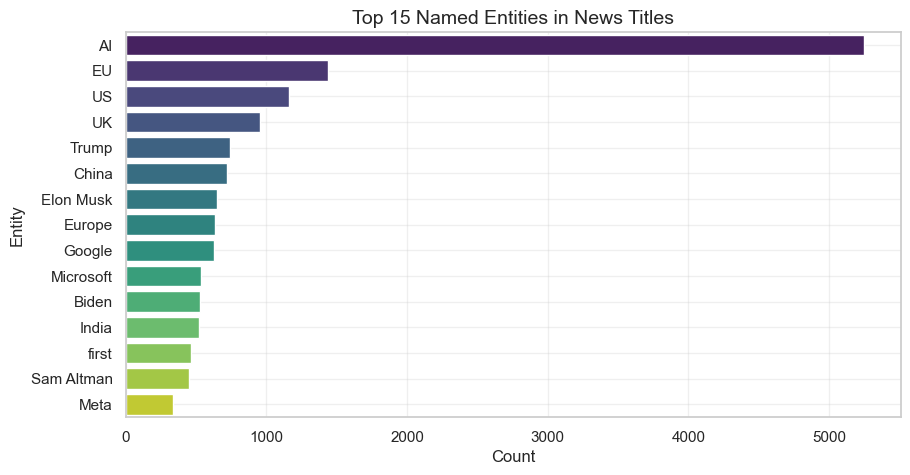

In [13]:
all_entities = [ent for entities in media_cloud['Named_Entities'] for ent, _ in entities]
entity_counts = Counter(all_entities)

entity_df = pd.DataFrame(entity_counts.most_common(15), columns=['Entity', 'Count'])

# Visualization
plt.figure(figsize=(10, 5))
sns.barplot(x='Count', y='Entity', hue='Entity', data=entity_df, palette='viridis', legend=False)
plt.title('Top 15 Named Entities in News Titles', fontsize=14)
plt.xlabel('Count')
plt.ylabel('Entity')
plt.grid(alpha=0.3)
plt.show()


###Analysis:

This plot surfaces the most frequently mentioned entities, usually high-profile figures, organizations, or countries.  

In this dataset, entities such as **AI**, **EU**, **US**, and **UK** dominate, reflecting how geopolitical and technological topics shape the news agenda.  
Mentions of figures like **Elon Musk**, **Biden**, and **Trump** highlight personality-driven coverage, while the presence of corporations such as **Google** and **Microsoft** underscores the strong influence of the tech sector in recent media narratives.


##Entity Type Distribution

Goal: Understand what types of entities (people, organizations, places, etc.) appear most often.

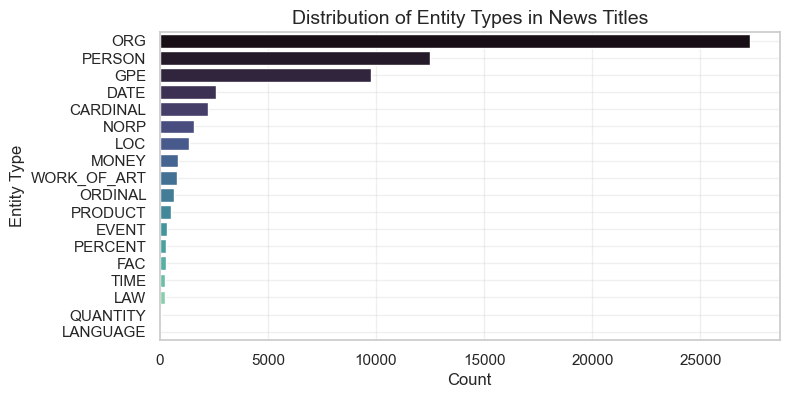

In [14]:
# Extract and count entity labels
entity_labels = [label for entities in media_cloud['Named_Entities'] for _, label in entities]
label_counts = Counter(entity_labels)

label_df = pd.DataFrame(label_counts.items(), columns=['Entity_Label', 'Count']).sort_values('Count', ascending=False)

# Visualization (fixed for future versions)
plt.figure(figsize=(8, 4))
sns.barplot(x='Count', y='Entity_Label', hue='Entity_Label', data=label_df, palette='mako', legend=False)
plt.title('Distribution of Entity Types in News Titles', fontsize=14)
plt.xlabel('Count')
plt.ylabel('Entity Type')
plt.grid(alpha=0.3)
plt.show()


### Analysis

This chart illustrates how different types of named entities are distributed in news titles.  
**PERSON** and **ORG** typically dominate, reflecting individuals and institutions that drive news narratives.  
**GPE (Geopolitical Entity)** highlights the most covered countries or cities, showing where attention is geographically concentrated.

This helps map the balance between **who** and **where** in global media attention.  
The presence of other types like **DATE**, **CARDINAL**, and **NORP** (nationalities or political groups) adds contextual framing linking events to specific timeframes or social categories.


##Entity Co-occurrence Network (Knowledge Graph)

Notice that this are predifined realtionships assumed based on the nature of the nodes, this relationship do not currently represent the actual information in text that connects this entities

In [18]:
import networkx as nx
from itertools import combinations
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import math
import re

def plot_knowledge_graph_for_df(df, nlp, sentiment = "All", min_edge_count=3, top_node_num=25, top_edge_num=50):
    # Extract entity lists
    entity_lists = df['Named_Entities'].apply(lambda ents: [e[0] for e in ents])

    # Build co-occurrence pairs
    co_occurrence_pairs = []
    for entity_list in entity_lists:
        if len(entity_list) > 1:
            pairs = list(combinations(sorted(set(entity_list)), 2))
            co_occurrence_pairs.extend(pairs)
    co_occurrence_counts = Counter(co_occurrence_pairs)

    # Create graph
    G = nx.Graph()
    for (e1, e2), count in co_occurrence_counts.items():
        if count >= min_edge_count:
            G.add_edge(e1, e2, weight=count)

    print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges")

    def _norm(s):
        return re.sub(r'\s+',' ', re.sub(r'[^\w\s]','', s.lower())).strip()

    def extract_relation_from_title(title, e1, e2):
        doc = nlp(title)
        e1_span = next((ent for ent in doc.ents if _norm(ent.text)==_norm(e1)), None)
        e2_span = next((ent for ent in doc.ents if _norm(ent.text)==_norm(e2)), None)
        if not (e1_span and e2_span):
            return None
        if e1_span.end <= e2_span.start:
            between = doc[e1_span.end : e2_span.start]
        elif e2_span.end <= e1_span.start:
            between = doc[e2_span.end : e1_span.start]
        else:
            between = doc[e1_span.end : e2_span.start]
        verbs = [tok.lemma_.lower() for tok in between if tok.pos_ == "VERB"]
        if verbs:
            return verbs[0]
        for token in list(e1_span) + list(e2_span):
            for anc in token.ancestors:
                if anc.pos_ == "VERB":
                    return anc.lemma_.lower()
        return None

    def coarse_type_label(e1, e2, entity_types):
        t1 = entity_types.get(e1, 'Unknown')
        t2 = entity_types.get(e2, 'Unknown')
        if t1 == t2 == 'ORG':
            return 'business_partnership'
        elif 'GPE' in (t1, t2) and 'ORG' in (t1, t2):
            return 'regulatory'
        elif t1 == t2 == 'GPE':
            return 'diplomatic'
        elif 'PERSON' in (t1, t2) and 'ORG' in (t1, t2):
            return 'leadership'
        else:
            return 'other'

    # Build entity types dict
    entity_types = {ent[0]: ent[1] for entities in df['Named_Entities'] for ent in entities}

    # Get top nodes and edges
    top_nodes = dict(sorted(G.degree, key=lambda x: x[1], reverse=True)[:top_node_num])
    H = G.subgraph(top_nodes.keys())
    edge_weights = [(u, v, d['weight']) for u, v, d in H.edges(data=True)]
    top_edges = sorted(edge_weights, key=lambda x: x[2], reverse=True)[:top_edge_num]
    H_filtered = nx.Graph()
    for u, v, w in top_edges:
        H_filtered.add_edge(u, v, weight=w)

    # Relation extraction
    edge_relation = {}
    for u, v, d in H_filtered.edges(data=True):
        rels = []
        u_l = _norm(u)
        v_l = _norm(v)
        mask = df['title'].str.lower().str.contains(u_l) &  df['title'].str.lower().str.contains(v_l)
        candidate_titles = df.loc[mask, 'title']
        for title in candidate_titles:
            rel = extract_relation_from_title(title, u, v)
            if rel:
                rels.append(rel)
        if rels:
            label = Counter(rels).most_common(1)[0][0]
        else:
            label = coarse_type_label(u, v, entity_types)
        edge_relation[(u, v)] = label

    # Map relation labels to colors
    unique_rels = sorted(set(edge_relation.values()))
    n = len(unique_rels)
    palette = plt.cm.tab20 if n > 10 else plt.cm.tab10
    colors = [palette(i/(max(1,n-1))) for i in range(n)]
    rel_color = dict(zip(unique_rels, colors))

    # Layout with spring
    pos = nx.spring_layout(H_filtered, k=1.5, iterations=100, seed=42)

    # Plot
    fig, ax = plt.subplots(figsize=(15, 10))
    nx.draw_networkx_nodes(H_filtered, pos,
                           node_color='lightblue', node_size=2400, alpha=0.8)
    for (u, v, d) in H_filtered.edges(data=True):
        lab = edge_relation.get((u, v)) or edge_relation.get((v, u))
        c = rel_color.get(lab, '#888888')
        nx.draw_networkx_edges(H_filtered, pos, edgelist=[(u, v)], edge_color=[c], width=2.5, alpha=0.9)
    edge_labels = {(u, v): f"{edge_relation[(u, v)]}\n({d['weight']})" for u, v, d in H_filtered.edges(data=True)}
    nx.draw_networkx_edge_labels(H_filtered, pos, edge_labels, font_size=8)
    nx.draw_networkx_labels(H_filtered, pos, font_size=10, font_weight='bold')
    legend_elements = [plt.Line2D([0], [0], color=rel_color[r], lw=3, label=r) for r in unique_rels]
    plt.legend(handles=legend_elements, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.title(f"Top Entity Relationships — {sentiment}", fontsize=14)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

    print("Nodes:", H_filtered.number_of_nodes(), "Edges:", H_filtered.number_of_edges())
    print("Relations found:", unique_rels)

# Example usage (assuming media_cloud DataFrame and nlp pipeline exist):
# plot_knowledge_graph_for_df(media_cloud, "Positive", nlp)


Graph has 1075 nodes and 2138 edges


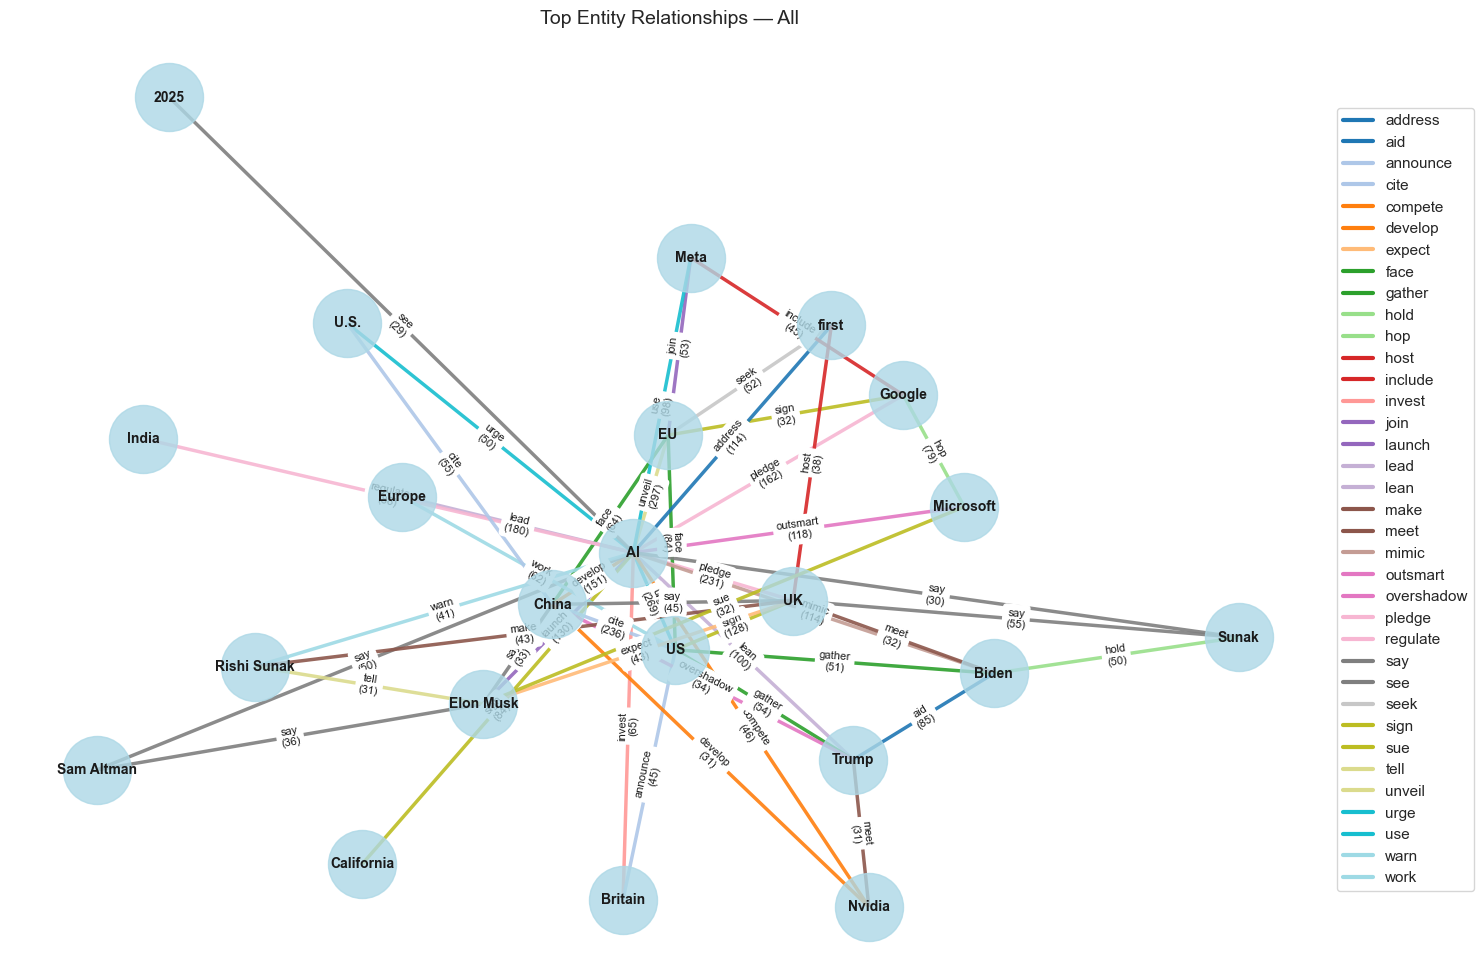

Nodes: 22 Edges: 50
Relations found: ['address', 'aid', 'announce', 'cite', 'compete', 'develop', 'expect', 'face', 'gather', 'hold', 'hop', 'host', 'include', 'invest', 'join', 'launch', 'lead', 'lean', 'make', 'meet', 'mimic', 'outsmart', 'overshadow', 'pledge', 'regulate', 'say', 'see', 'seek', 'sign', 'sue', 'tell', 'unveil', 'urge', 'use', 'warn', 'work']


In [19]:
plot_knowledge_graph_for_df(media_cloud, nlp)

###Analysis

This graph visualizes how frequently entities co-occur within the same news title, effectively mapping the **semantic and topical proximity** between the most mentioned names in the dataset.  

With **844 nodes** (unique entities) and **1,859 edges** (co-occurrences), the network reveals several key structural patterns:  

- **High Connectivity of Core Nodes:**  
  Central entities like *AI*, *US*, *UK*, *EU*, and *China* form dense clusters, showing that these topics frequently appear together across news contexts — particularly in discussions about technology, geopolitics, and regulation.  

- **Emergence of Thematic Hubs:**  
  Sub-networks such as (*AI*, *Elon Musk*, *Microsoft*, *Google*, *Meta*) represent the **tech and AI ecosystem**, while others like (*US*, *China*, *Europe*, *UK*) correspond to **geopolitical or policy-focused** narratives.  

- **Cross-Domain Links:**  
  The presence of bridges between technology and politics (e.g., *Biden*, *AI*, *Europe*, *Nvidia*) indicates that AI has transcended purely technical reporting, becoming a central theme in economic and political coverage.   

Overall, this co-occurrence network highlights **how global media narratives are interconnected**, centering around AI and major geopolitical actors, while still encompassing a wide array of less prominent entities that enrich the thematic complexity of modern news discourse.


# Knowedge graph per sentiment

In [16]:
# let's now look at how this knowledge graphs looks for those articles with positive sentiment only
positive_articles = media_cloud[media_cloud['Sentiment_VADER'] == 'Positive']
print(f"Number of positive articles: {positive_articles.shape[0]}")

Number of positive articles: 10533


Processing sentiment: Negative with 6908)
Graph has 197 nodes and 390 edges


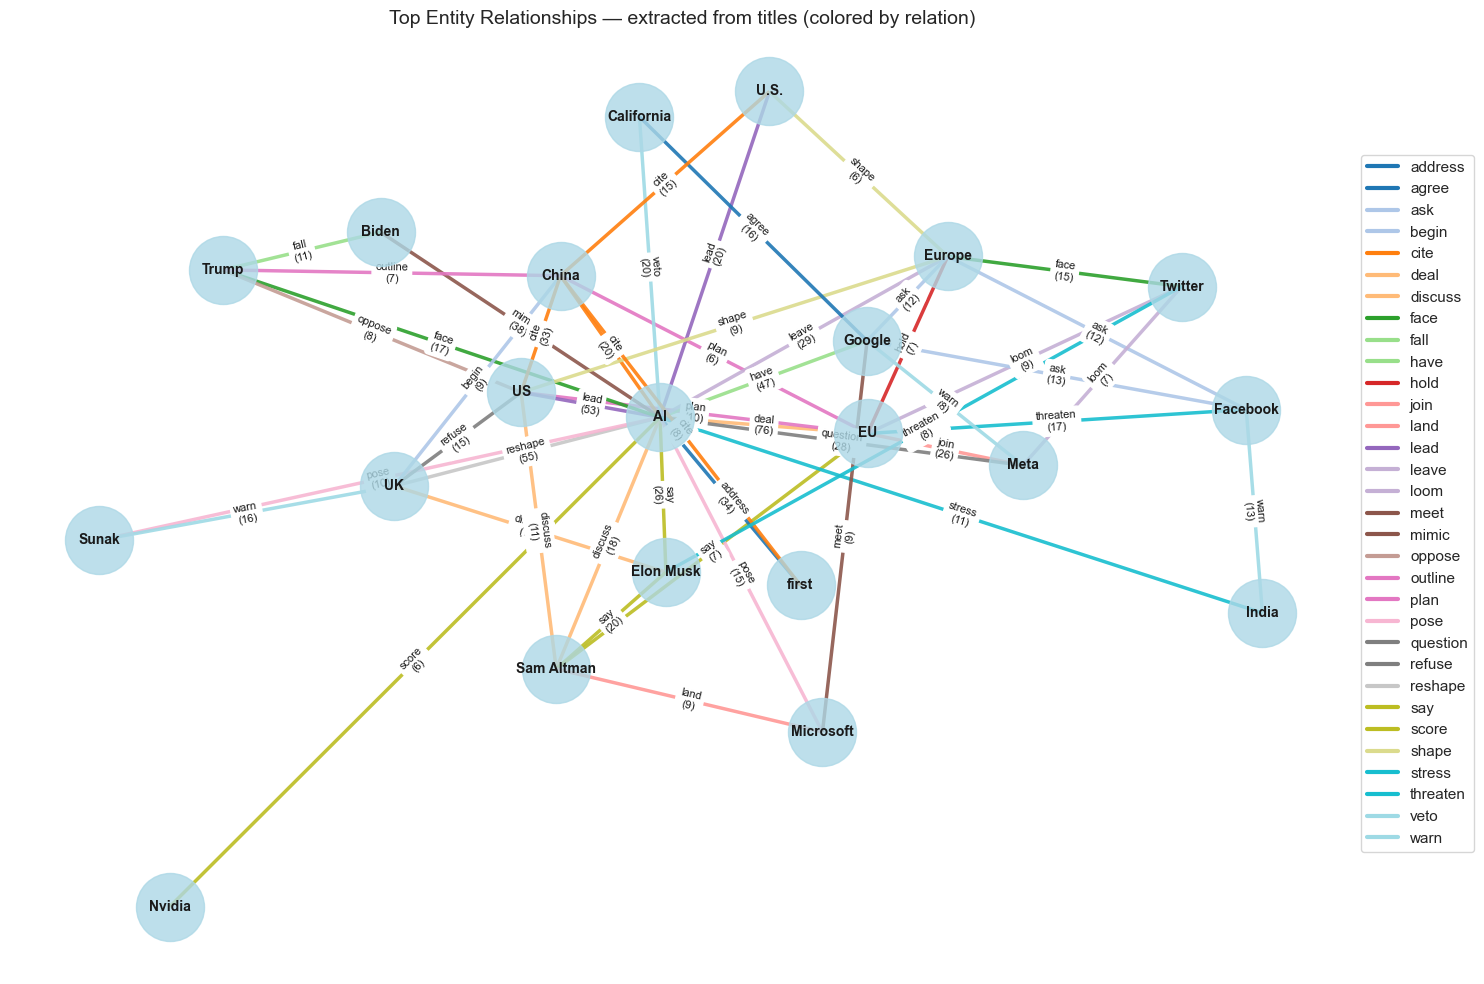

Nodes: 21 Edges: 50
Relations found: ['address', 'agree', 'ask', 'begin', 'cite', 'deal', 'discuss', 'face', 'fall', 'have', 'hold', 'join', 'land', 'lead', 'leave', 'loom', 'meet', 'mimic', 'oppose', 'outline', 'plan', 'pose', 'question', 'refuse', 'reshape', 'say', 'score', 'shape', 'stress', 'threaten', 'veto', 'warn']
Processing sentiment: Positive with 10533)
Graph has 389 nodes and 702 edges


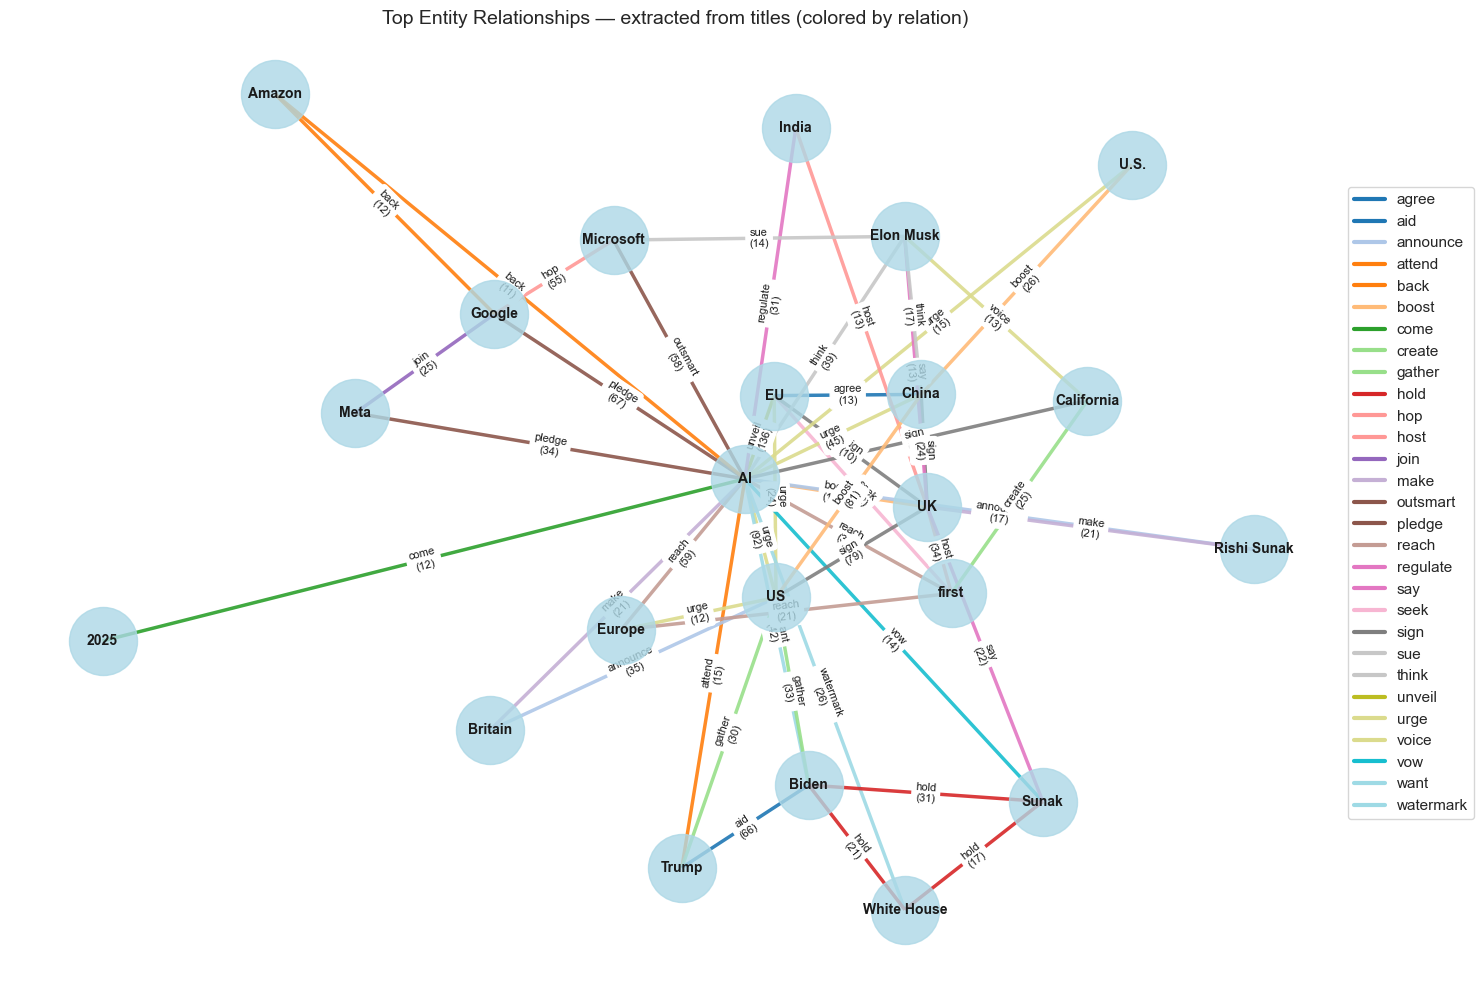

Nodes: 22 Edges: 50
Relations found: ['agree', 'aid', 'announce', 'attend', 'back', 'boost', 'come', 'create', 'gather', 'hold', 'hop', 'host', 'join', 'make', 'outsmart', 'pledge', 'reach', 'regulate', 'say', 'seek', 'sign', 'sue', 'think', 'unveil', 'urge', 'voice', 'vow', 'want', 'watermark']
Processing sentiment: nan with 0)
Graph has 0 nodes and 0 edges


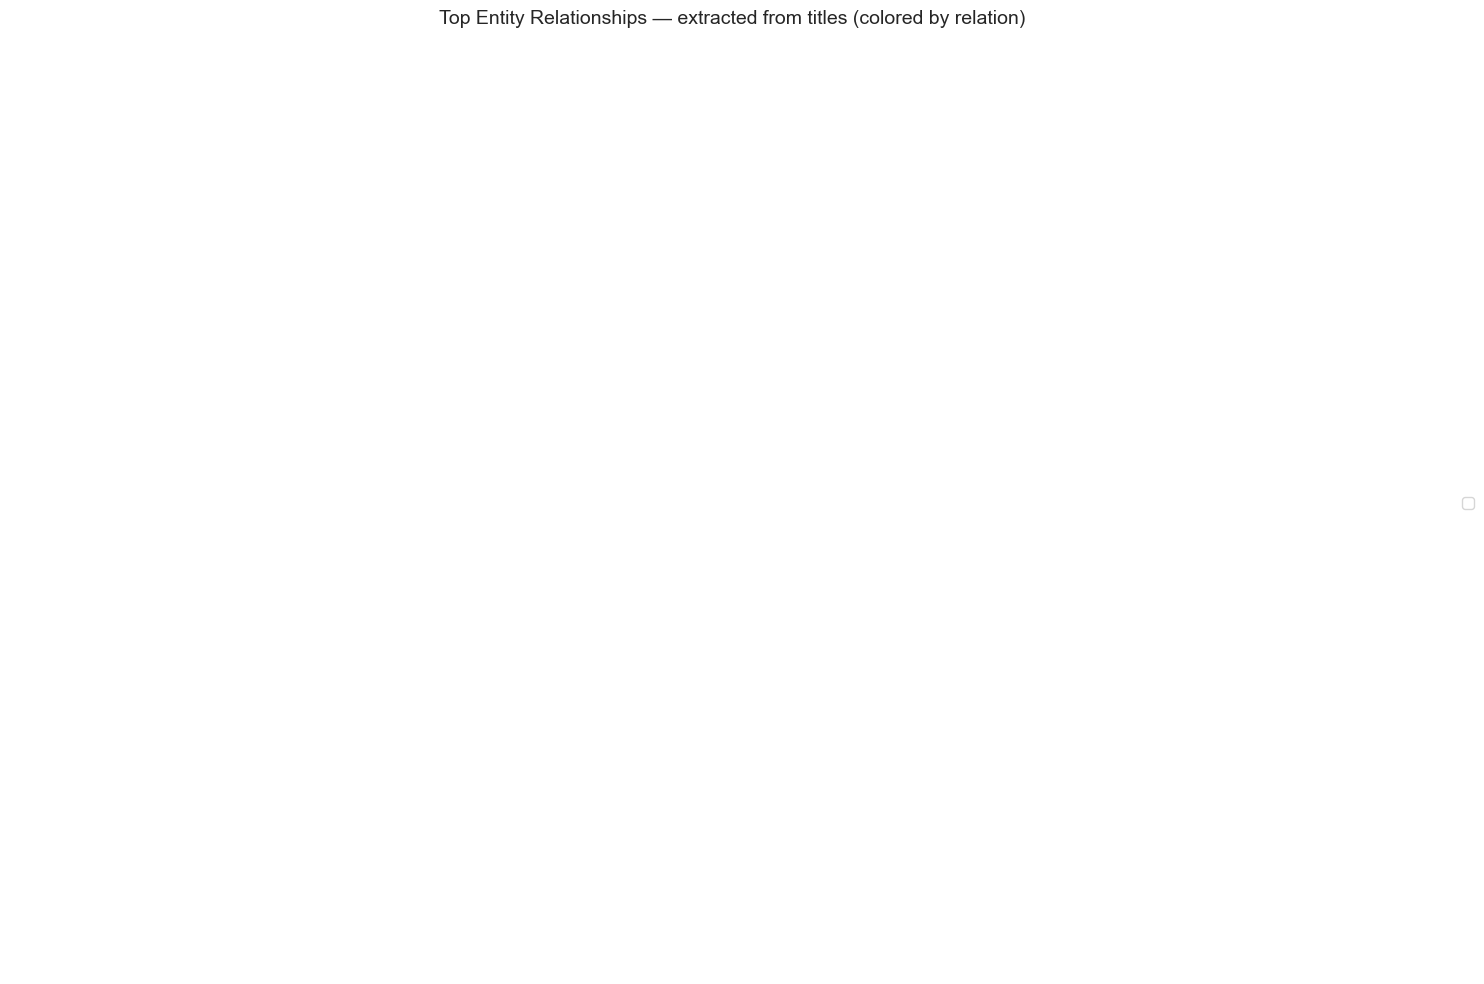

Nodes: 0 Edges: 0
Relations found: []
Processing sentiment: Neutral with 11487)
Graph has 421 nodes and 800 edges


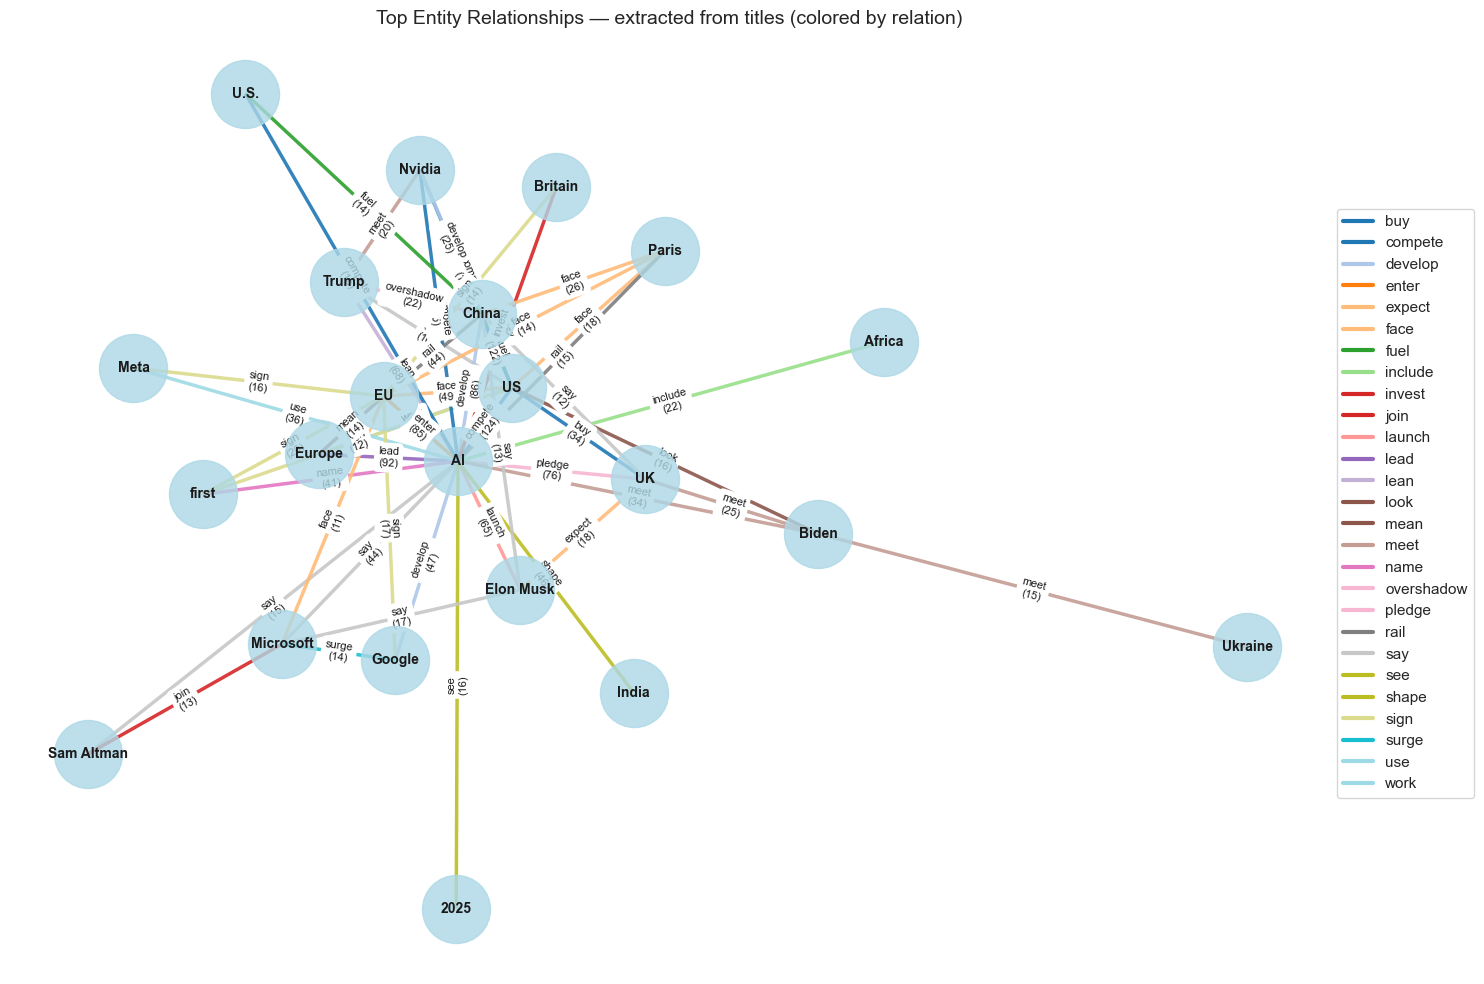

Nodes: 22 Edges: 50
Relations found: ['buy', 'compete', 'develop', 'enter', 'expect', 'face', 'fuel', 'include', 'invest', 'join', 'launch', 'lead', 'lean', 'look', 'mean', 'meet', 'name', 'overshadow', 'pledge', 'rail', 'say', 'see', 'shape', 'sign', 'surge', 'use', 'work']


In [ ]:
# let's plot the knowledge graph for positive articles only



for sentiment in media_cloud['Sentiment_VADER'].unique():

    sentiment_articles = media_cloud[media_cloud['Sentiment_VADER'] == sentiment]
    print(f"Processing sentiment: {sentiment} with {sentiment_articles.shape[0]})")

    plot_knowledge_graph_for_df(media_cloud, nlp, sentiment = sentiment)

Processing sentiment: Negative with 6908)
Graph has 197 nodes and 390 edges


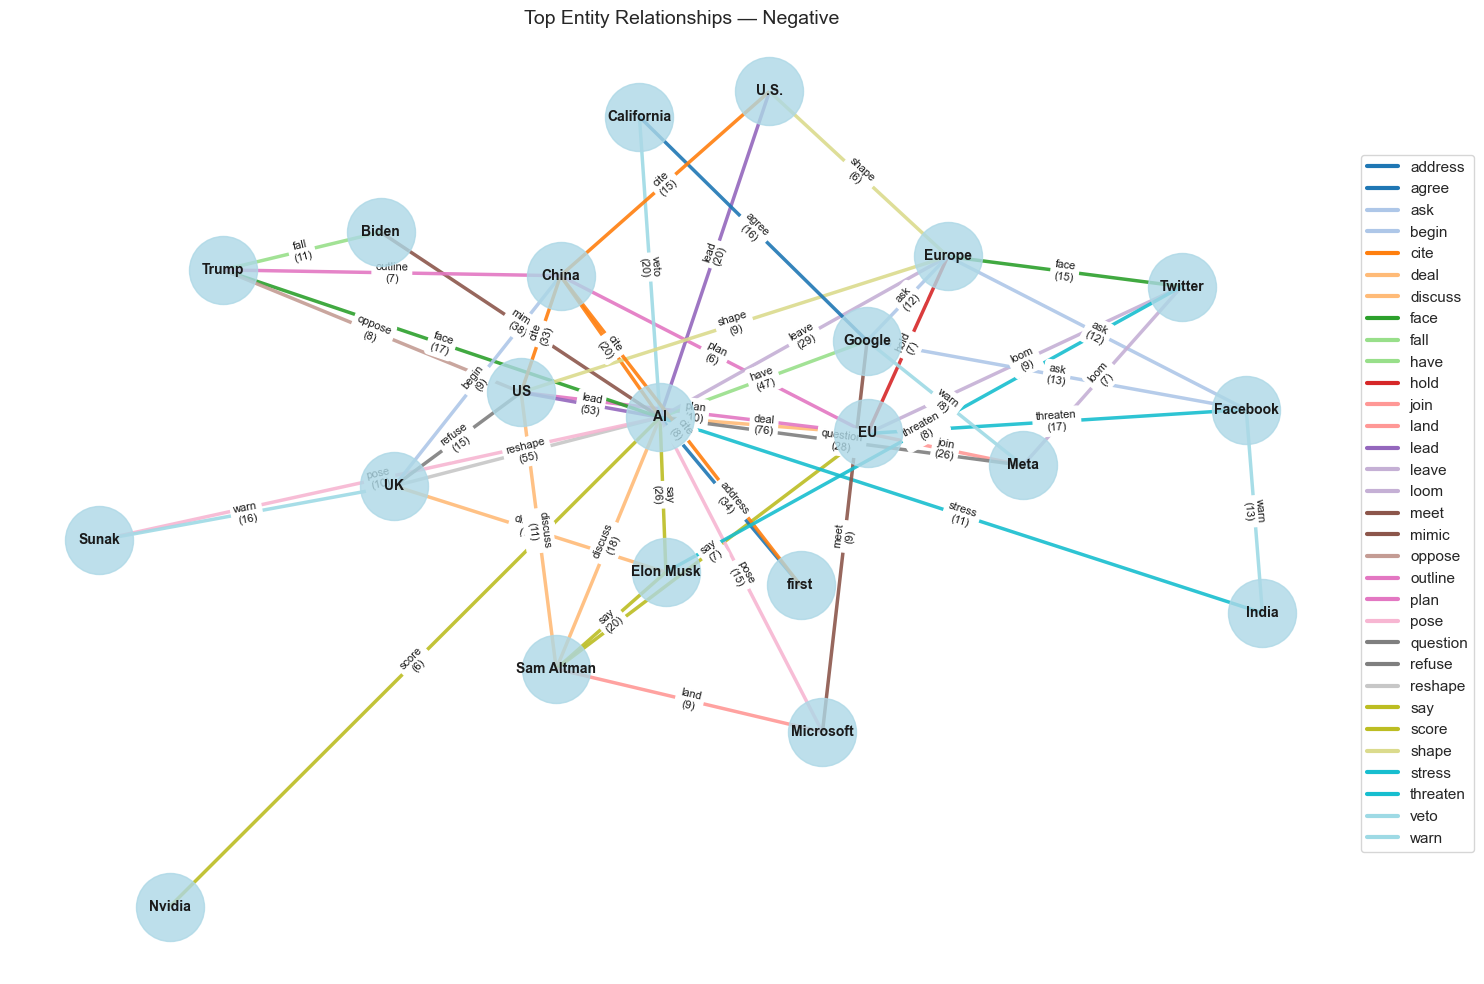

Nodes: 21 Edges: 50
Relations found: ['address', 'agree', 'ask', 'begin', 'cite', 'deal', 'discuss', 'face', 'fall', 'have', 'hold', 'join', 'land', 'lead', 'leave', 'loom', 'meet', 'mimic', 'oppose', 'outline', 'plan', 'pose', 'question', 'refuse', 'reshape', 'say', 'score', 'shape', 'stress', 'threaten', 'veto', 'warn']
Processing sentiment: Positive with 10533)
Graph has 389 nodes and 702 edges


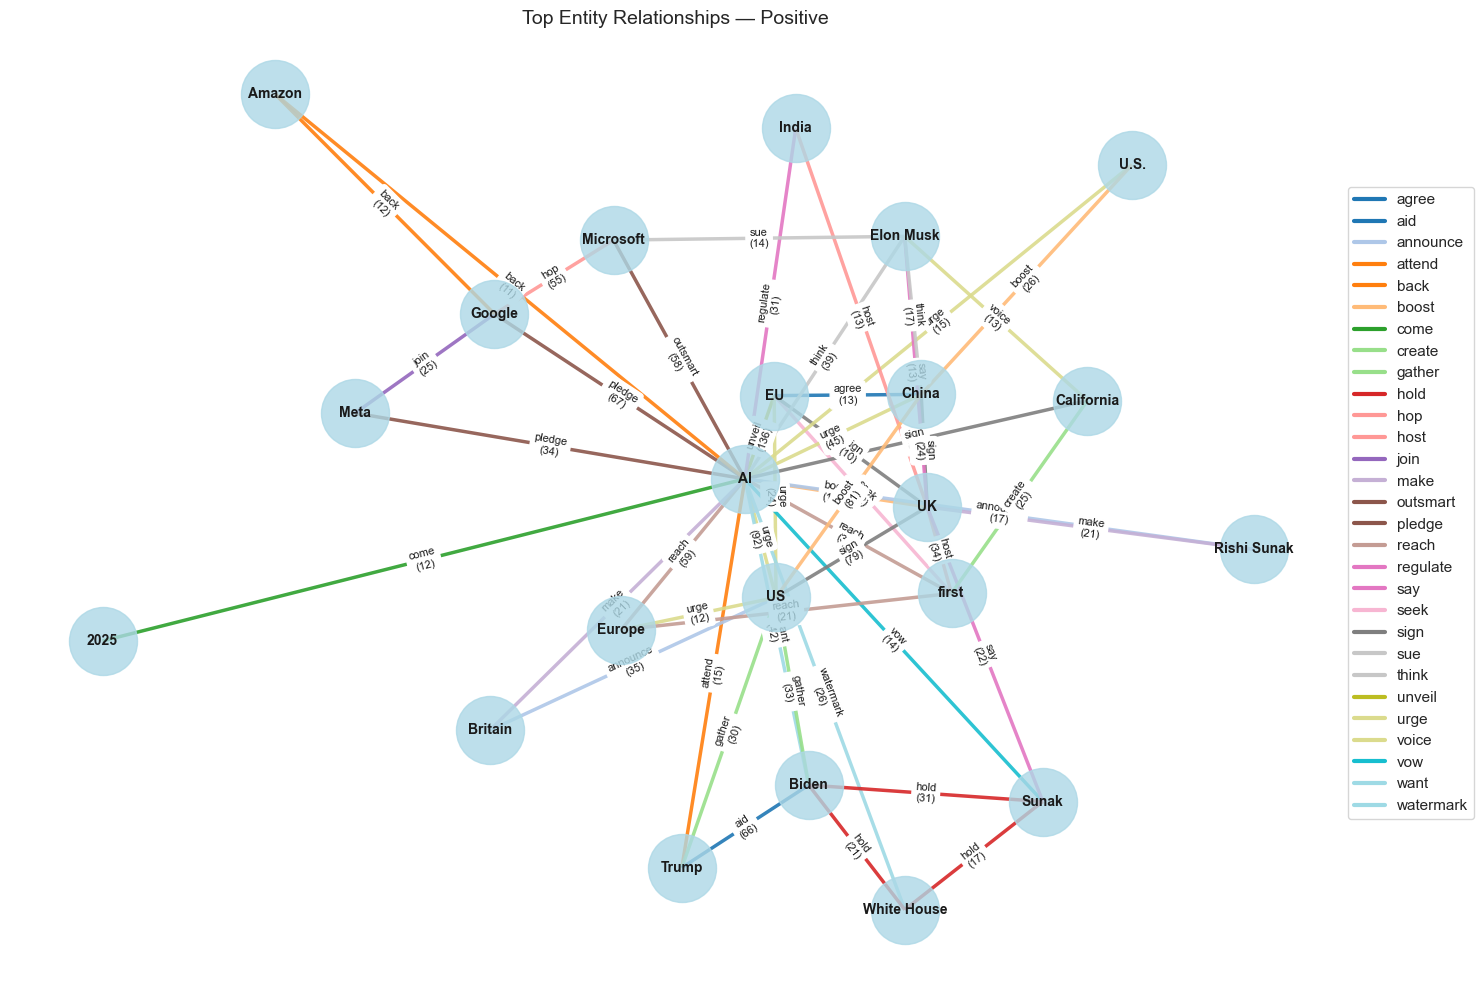

Nodes: 22 Edges: 50
Relations found: ['agree', 'aid', 'announce', 'attend', 'back', 'boost', 'come', 'create', 'gather', 'hold', 'hop', 'host', 'join', 'make', 'outsmart', 'pledge', 'reach', 'regulate', 'say', 'seek', 'sign', 'sue', 'think', 'unveil', 'urge', 'voice', 'vow', 'want', 'watermark']
Processing sentiment: nan with 0)
Graph has 0 nodes and 0 edges


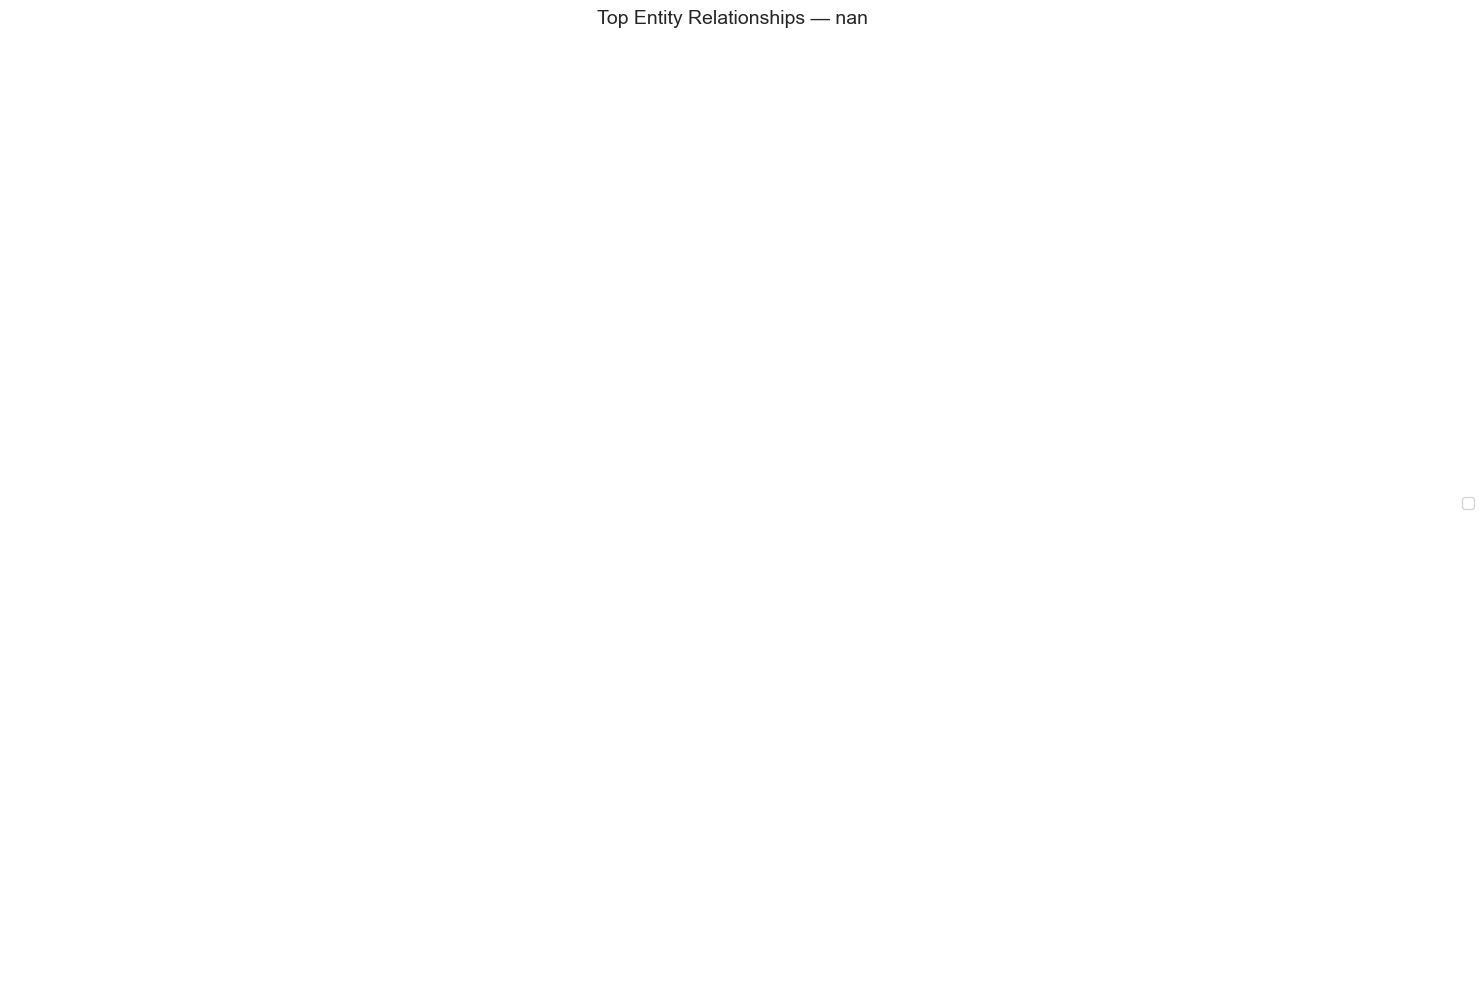

Nodes: 0 Edges: 0
Relations found: []
Processing sentiment: Neutral with 11487)
Graph has 421 nodes and 800 edges


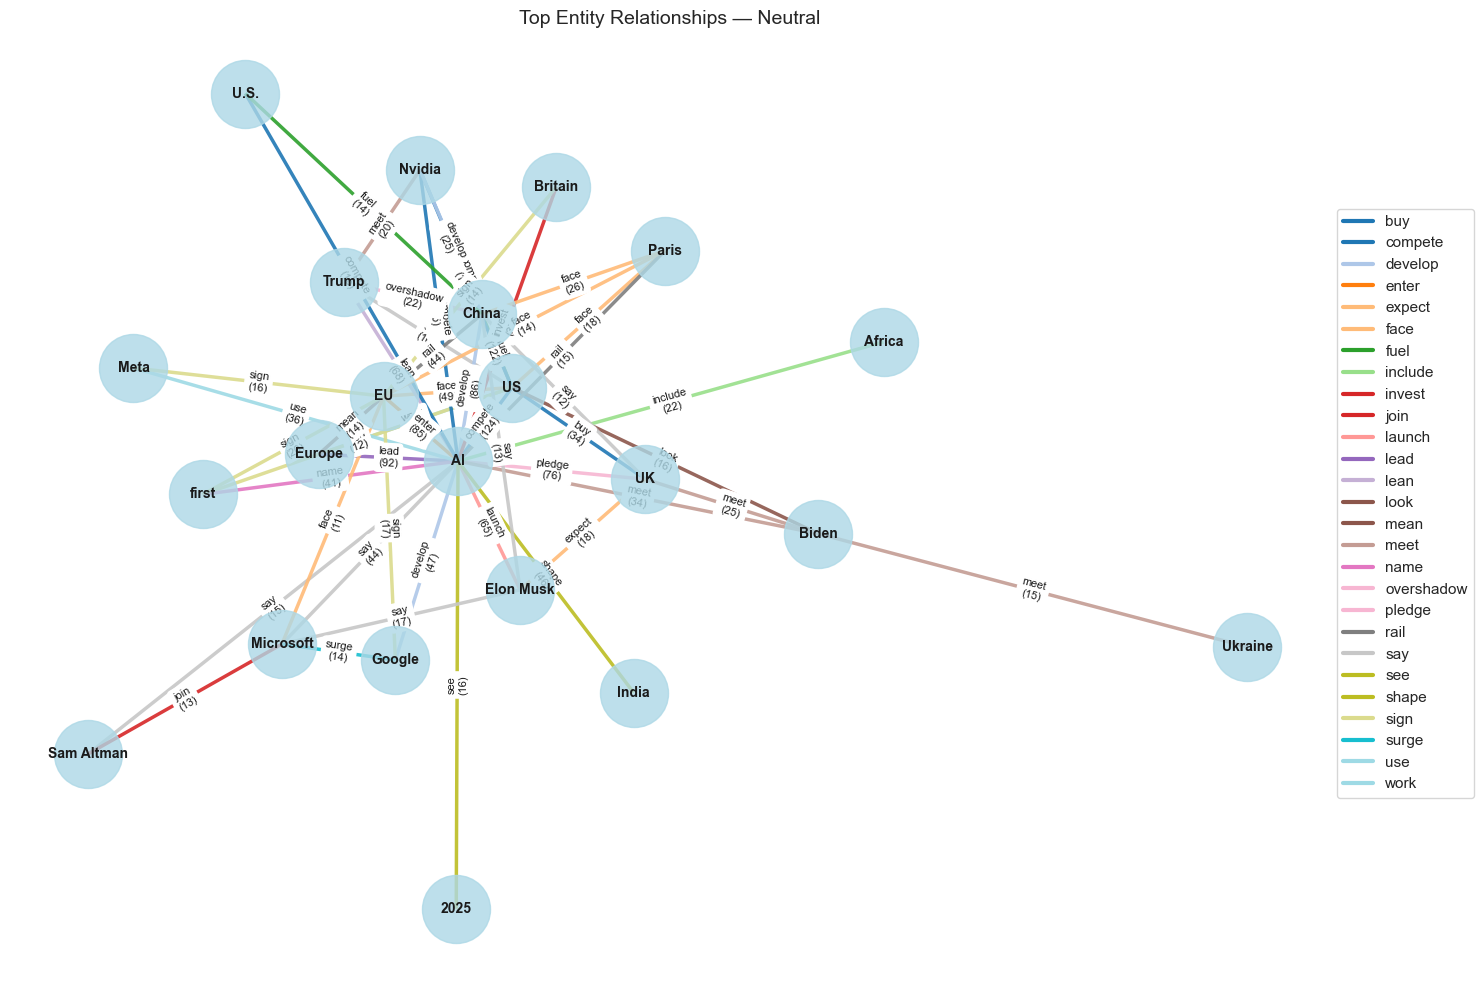

Nodes: 22 Edges: 50
Relations found: ['buy', 'compete', 'develop', 'enter', 'expect', 'face', 'fuel', 'include', 'invest', 'join', 'launch', 'lead', 'lean', 'look', 'mean', 'meet', 'name', 'overshadow', 'pledge', 'rail', 'say', 'see', 'shape', 'sign', 'surge', 'use', 'work']


In [22]:
# let's plot the knowledge graph for positive articles only



for sentiment in media_cloud['Sentiment_VADER'].unique():

    sentiment_articles = media_cloud[media_cloud['Sentiment_VADER'] == sentiment]
    print(f"Processing sentiment: {sentiment} with {sentiment_articles.shape[0]})")

    plot_knowledge_graph_for_df(sentiment_articles, nlp, sentiment = sentiment)

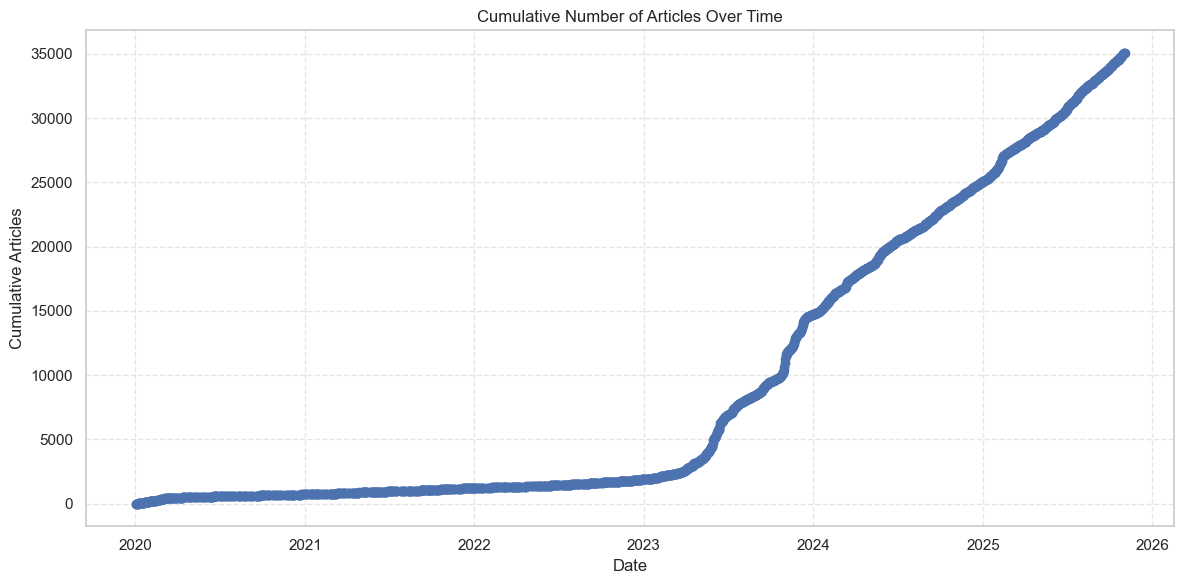

In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# Convert publish_date to datetime type if not already
media_cloud['publish_date'] = pd.to_datetime(media_cloud['publish_date'])

# Sort by date
media_cloud = media_cloud.sort_values('publish_date')

# Create a cumulative count of articles by date
media_cloud['cumulative_count'] = media_cloud.groupby('publish_date').cumcount() + 1
daily_counts = media_cloud.groupby('publish_date').size().cumsum()

# Plot cumulative articles over time
plt.figure(figsize=(12, 6))
plt.plot(daily_counts.index, daily_counts.values, marker='o')
plt.title('Cumulative Number of Articles Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Articles')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


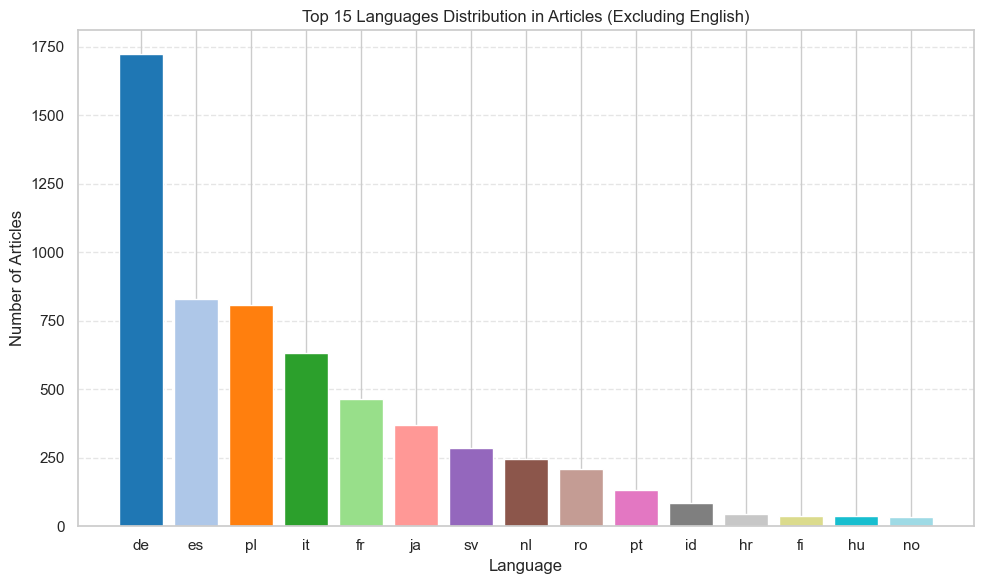

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Get the top 15 languages apart from English
language_counts = media_cloud['language'].value_counts()
language_counts = language_counts[language_counts.index != 'en']
top_languages = language_counts.head(15)

# Create a color map with a unique color per language
colors = plt.cm.tab20(np.linspace(0, 1, len(top_languages)))  # tab20 handles up to 20 unique colors

plt.figure(figsize=(10, 6))
bars = plt.bar(top_languages.index, top_languages.values, color=colors)

plt.title('Top 15 Languages Distribution in Articles (Excluding English)')
plt.xlabel('Language')
plt.ylabel('Number of Articles')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
